# Experiment objective
From the experiments on the Bonferroni bound, we conclude that there are two factors that effect the effectiveness of the Bonferroni bound: pairwise correlation of the conformity scores and distrition shape of the scores, the former controls the tightness whereas the later controls the change in the size.

The purpose of the notebook is to explore this two factors with real matrix completion method.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../pairedRS')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

(CVXPY) Oct 26 04:17:43 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [41]:
# Some useful functions

def get_scores(n, a=1, b=1, random_state=0):  
    rng = np.random.default_rng(random_state)
    scores = rng.beta(a, b, n)
    return scores


# Bonferroni
def get_bon_qnt(scores, alpha):
    st_scores = np.sort(scores)
    alpha_corrected = alpha / 2
    bon_qnt = np.quantile(st_scores, 1 - alpha_corrected, method="lower")
    return bon_qnt, st_scores


def get_conformal_qnt(scores, alpha, pair_method):
    if pair_method == "indep":
        # pairs are picked at random
        pairs = [[scores[2*i], scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    elif pair_method == "pos_cor":
        # similar scores are grouped
        st_scores = np.sort(scores)
        pairs = [[st_scores[2*i], st_scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
    
    elif pair_method == "neg_cor":
        st_scores = np.sort(scores)
        pairs = [[st_scores[i], st_scores[-(i+1)]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    st_pair_scores = np.sort(pair_scores)
    conformal_qnt = np.quantile(st_pair_scores, 1 - alpha, method="lower")
    return st_pair_scores, conformal_qnt


def plot_st(st_pair_scores, st_scores, conformal_qnt, bon_qnt, n, alpha , x_max=None, y_min=None):
    fig, ax = plt.subplots(1, 3, figsize=(14, 3))
    px = np.arange(1, n//2 + 1) / (n//2)
    h_spacing = bon_qnt/50
    v_spacing = alpha/5
    
    ax[0].plot(st_pair_scores, px)
    ax[0].axhline(y=1-alpha, color='red', linestyle='--')
    ax[0].axvline(x=conformal_qnt, color='blue', linestyle='--')
    ax[0].set_title("Paired scores cdf")
    ax[0].set_xlabel("Paired scores")
    ax[0].set_ylabel("Quantiles")
    ax[0].plot(conformal_qnt, 1-alpha, 'ro')
    ax[0].annotate(f'threshold:{conformal_qnt:.4f}', (conformal_qnt-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[0].annotate(f'quantile:{1-alpha:.2f}', (conformal_qnt-h_spacing, 1-alpha+v_spacing), fontsize=10, color='red', ha='right')
    if x_max is None:
        ax[0].set_xlim(0,  conformal_qnt+5*h_spacing)
    else:
        ax[0].set_xlim(0,  x_max)
        
    x = np.arange(1, n + 1) / n
    ax[1].plot(st_scores, x)
    ax[1].axhline(y=1-alpha/2, color='red', linestyle='--', label='Vertical Line')
    ax[1].axvline(x=bon_qnt, color='blue', linestyle='--')
    ax[1].set_title("Scores cdf")
    ax[1].set_xlabel("Scores")
    ax[1].set_ylabel("Quantiles")
    ax[1].plot(bon_qnt, 1-alpha/2, 'ro')
    ax[1].annotate(f'threshold:{bon_qnt:.4f}', (bon_qnt-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[1].annotate(f'quantile:{1-alpha/2:.2f}', (bon_qnt-h_spacing, 1-alpha/2+v_spacing), fontsize=10, color='red', ha='right')
    if x_max is None:
        ax[1].set_xlim(0,  bon_qnt+5*h_spacing)
    else:
        ax[1].set_xlim(0,  x_max)
        
        
    ax[2].plot(st_pair_scores, px, color='blue', label='Paired')
    ax[2].plot(st_scores, x, color='red', label= 'Unpaired')
    ax[2].axhline(y=1-alpha, color='blue', linestyle='--')
    ax[2].axhline(y=1-alpha/2, color='red', linestyle='--')
    ax[2].set_xlabel("Scores")
    ax[2].set_ylabel("Quantiles")
    if x_max is None:
        ax[2].set_xlim(0,  np.max([bon_qnt+5*h_spacing, conformal_qnt+5*h_spacing]))
    else:
        ax[2].set_xlim(0,  x_max)
    ax[2].legend()
    
    if y_min is None:
        for a in ax:
            a.set_ylim(0.5, 1)
    
    print("Paired quantile is {}, Bonferroni quantile is {}".format(conformal_qnt, bon_qnt))
    print("Interval size ratio (Bonferroni/conformal) is {}".format(bon_qnt/conformal_qnt))

# Experiment 1
Replicate the postive correlation among the pairs chosen from the hpm model. 

In [993]:
# Matrix shape and rank
n1, n2 = 100,100
r = 3
prob_obs = 0.3
random_state = 30
alpha = 0.1
allow_inf = False

In [994]:
sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

# Sample observation mask
mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs

# Sample calibration pairs following hpm
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)

# Sample test pairs
n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
_, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)

In [995]:
# Generate a random true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M_true = RFM.sample_noiseless(0)

In [1028]:
# Generate a noisy matrix
def get_noisy(M, gamma, random_state=0):
    rng = np.random.default_rng(random_state)
    
    n1, n2 = M.shape
    
    row_noise = rng.normal(0,1,n1)
    noise = np.transpose(np.tile(row_noise, (n2,1)))
    
    # normalize
    #noise /= np.max(noise)
    #M /= np.max(M)
    
    # gamma represents the noise ratio
    M = (1-gamma)*M + gamma*noise
    
    return M 

In [1035]:
gamma = 1
M = get_noisy(M_true, gamma, random_state=random_state)

In [1036]:
print("HPM model\n"+"-"*25)
print('Running matrix completion algorithm...')
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=1, random_state=random_state, verbose=False)
#Mhat= svt_solve(M, mask_train, max_iterations=200, random_state=random_state, verbose=False)
print('Done!')

HPM model
-------------------------
Running matrix completion algorithm...
Done!


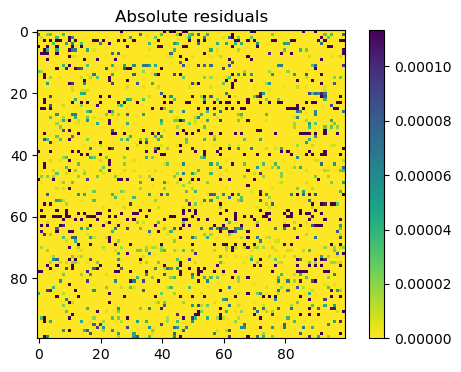

In [1037]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [1038]:
ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)

In [1039]:
st_pair_scores = ci_method.st_calib_scores
conformal_qnt = np.quantile(st_pair_scores, 1 - alpha, method="lower")

scores = np.abs((M-Mhat)[np.where(mask_calib==1)])
bon_qnt, st_scores = get_bon_qnt(scores, alpha)

Paired quantile is 0.2120044493626771, Bonferroni quantile is 0.2646804539621334
Interval size ratio (Bonferroni/conformal) is 1.2484665051031227


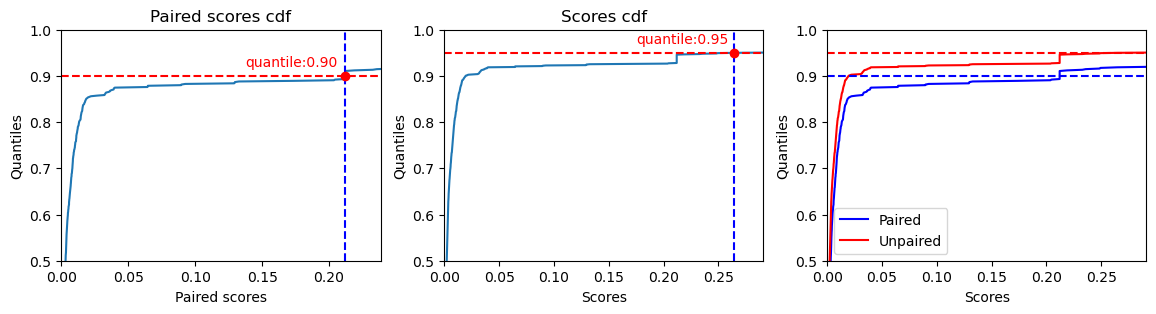

In [1040]:
plot_st(st_pair_scores, st_scores, conformal_qnt, bon_qnt, len(st_scores), alpha)

In [1046]:
def run_experiment(M_true, r, gamma, random_state=0):
    #------------------#
    # Fixed parameters #
    #------------------#
    n1, n2 = M_true.shape
    prob_obs = 0.5
    allow_inf = False
    
    methods = [
    #"conformal",      
    "naive",          # Naive conformal assuming all pairs are exchangeable 
    "bonferroni",     
    #"uncorrected" 
    ]
    
    #---------------------------------#
    # Sample masks, calib, test pairs #
    #---------------------------------#
    sampler = PairSampling(n1,n2)
    size_obs = n1 * n2 * prob_obs
    n_calib_pairs = int(size_obs//4)

    # Sample observation mask
    mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
    mask_test = np.ones_like(mask_obs) - mask_obs

    # Sample calibration pairs following hpm
    mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)
    
    # Sample test pairs
    n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
    _, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)
    
    
    #---------------------#
    # Generate estimation #
    #---------------------#
    M = get_noisy(M_true, gamma, random_state=random_state)
    Mhat, _, _ = pmf_solve(M, mask_train, k=r, random_state=random_state, verbose=False)
    
    
    #------------------#
    # Apply CI methods #
    #------------------#
    res = pd.DataFrame({})
    
    for method in methods:
        is_inf = np.zeros(n_test_pairs)
        if method == "conformal":
            ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
            lower, upper, is_inf, _ = ci_method.get_CI(idxs_test, alpha, allow_inf) 
        elif method == "naive":
            ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
            lower, upper = ci_method.naive_CI(idxs_test, alpha)       
        elif method == "bonferroni":
            lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)
        else:
            lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, 2 * alpha)

        res = pd.concat([res, evaluate_pairedCI(lower, upper, M, idxs_test, is_inf=is_inf, method=method)])

    
    res['Calib_size'] = n_calib_pairs
    res['Train_size'] = np.sum(mask_train)
    res['Test_size'] = n_test_pairs
    res['r'] = r
    res['gamma'] = gamma
    res['random_state'] = random_state
    
    return res

In [1055]:
# Experiment parameters
n1, n2 = 100, 100
r_list = np.arange(2,11)
gamma=0
repetition=10
model_seed=2023

In [1056]:
result = pd.DataFrame({})
for r in r_list:
    # Generate a random true matrix 
    RFM = RandomFactorizationModel(n1 ,n2, r)
    U, V, M_true = RFM.sample_noiseless(model_seed)
    for i in range(repetition):
        res = run_experiment(M_true, r, gamma, random_state=i)
        result = pd.concat([result, res])

Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs..

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test p

In [1057]:
result_filtered = result[(result.Method=='bonferroni')|(result.Method=='naive')]
bon_res = result[(result.Method=='bonferroni')].drop(columns=['Method'])
conformal_res = result[(result.Method=='naive')].drop(columns=['Method'])

bon_res = bon_res.rename(columns = {"Pair_coverage": "Bonferroni_Pair_coverage", 
                          "Coverage":"Bonferroni_Coverage",
                          "Size": "Bonferroni_Size",
                          "Inf_prop": "Bonferroni_Inf_prop"}).reset_index(drop=True)
conformal_res = conformal_res.rename(columns = {"Pair_coverage": "Conformal_Pair_coverage", 
                          "Coverage":"Conformal_Coverage",
                          "Size": "Conformal_Size",
                          "Inf_prop": "Conformal_Inf_prop"}).reset_index(drop=True)

res=bon_res.merge(conformal_res, on=['Calib_size', 'Train_size', 'Test_size', 'r',  'gamma', 'random_state'])
res['Ratio'] = res['Bonferroni_Size'] / res['Conformal_Size']

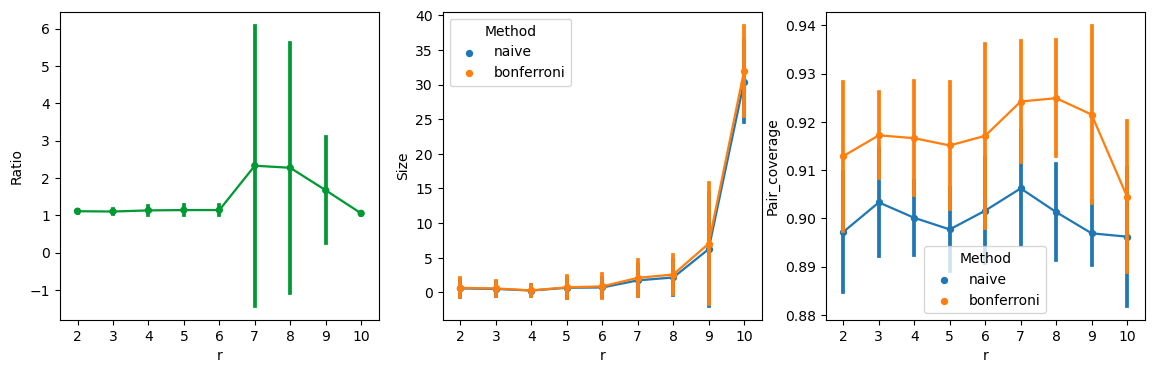

In [1058]:
# Make plot
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.pointplot(data=res, x="r", y="Ratio", color="#009933", errorbar='sd', hue=None, scale=0.6, ax=ax[0])

sns.pointplot(data=result_filtered, x="r", y="Size", hue='Method', errorbar='sd', scale=0.6, ax=ax[1])
sns.pointplot(data=result_filtered, x="r", y="Pair_coverage", hue='Method', errorbar='sd', ax=ax[2], scale=0.6)

plt.show()

In [1062]:
# Experiment parameters
n1, n2 = 100, 100
r = 8
gamma_list = np.linspace(0,1,6)
gamma_list = [ round(gamma, 1) for gamma in gamma_list ]  # avoid floating point issues
repetition=10
model_seed=2023

In [1063]:
gamma_list

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [1064]:
# Fix a true matrix 
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M_true = RFM.sample_noiseless(model_seed)

result = pd.DataFrame({})
for gamma in gamma_list:
    for i in range(repetition):
        res = run_experiment(M_true, r, gamma, random_state=i)
        result = pd.concat([result, res])

Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs..

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test p

In [1065]:
result_filtered = result[(result.Method=='bonferroni')|(result.Method=='naive')]
bon_res = result[(result.Method=='bonferroni')].drop(columns=['Method'])
conformal_res = result[(result.Method=='naive')].drop(columns=['Method'])

bon_res = bon_res.rename(columns = {"Pair_coverage": "Bonferroni_Pair_coverage", 
                          "Coverage":"Bonferroni_Coverage",
                          "Size": "Bonferroni_Size",
                          "Inf_prop": "Bonferroni_Inf_prop"}).reset_index(drop=True)
conformal_res = conformal_res.rename(columns = {"Pair_coverage": "Conformal_Pair_coverage", 
                          "Coverage":"Conformal_Coverage",
                          "Size": "Conformal_Size",
                          "Inf_prop": "Conformal_Inf_prop"}).reset_index(drop=True)

res=bon_res.merge(conformal_res, on=['Calib_size', 'Train_size', 'Test_size', 'r',  'gamma', 'random_state'])
res['Ratio'] = res['Bonferroni_Size'] / res['Conformal_Size']

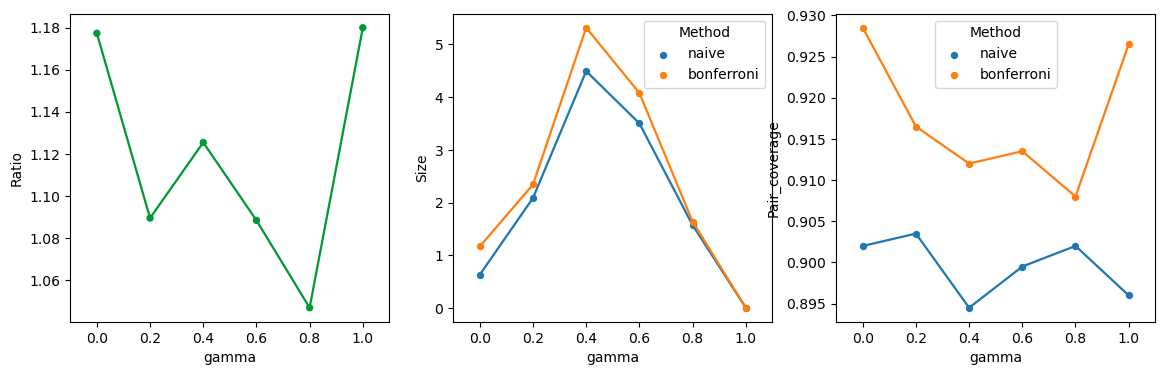

In [1070]:
# Make plot
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.pointplot(data=res, x="gamma", y="Ratio", color="#009933", estimator='median', errorbar=None, hue=None, scale=0.6, ax=ax[0])

sns.pointplot(data=result_filtered, x="gamma", y="Size", hue='Method', estimator='median', errorbar=None, scale=0.6, ax=ax[1])
sns.pointplot(data=result_filtered, x="gamma", y="Pair_coverage", hue='Method', estimator='median', errorbar=None, ax=ax[2], scale=0.6)

plt.show()

In [1067]:
res

,Bonferroni_Pair_coverage,Bonferroni_Coverage,Bonferroni_Size,Bonferroni_Inf_prop,Calib_size,Train_size,Test_size,r,gamma,random_state,Conformal_Pair_coverage,Conformal_Coverage,Conformal_Size,Conformal_Inf_prop,Ratio
0,0.934,0.9510,0.096988,0.0,1250,2500.0,1000,8,0.0,0,0.895,0.9265,0.065838,0.0,1.473128
1,0.938,0.9510,0.104862,0.0,1250,2500.0,1000,8,0.0,1,0.907,0.9325,0.077120,0.0,1.359729
2,0.927,0.9560,5.011008,0.0,1250,2500.0,1000,8,0.0,2,0.911,0.9460,4.311136,0.0,1.162341
3,0.936,0.9600,7.383838,0.0,1250,2500.0,1000,8,0.0,3,0.911,0.9455,6.193450,0.0,1.192201
4,0.921,0.9465,1.367325,0.0,1250,2500.0,1000,8,0.0,4,0.906,0.9370,1.188231,0.0,1.150724
5,0.930,0.9525,0.067363,0.0,1250,2500.0,1000,8,0.0,5,0.898,0.9325,0.054450,0.0,1.237146
6,0.904,0.9470,0.050895,0.0,1250,2500.0,1000,8,0.0,6,0.884,0.9350,0.047311,0.0,1.075762
7,0.905,0.9445,4.488182,0.0,1250,2500.0,1000,8,0.0,7,0.893,0.9380,3.929986,0.0,1.142035
8,0.923,0.9585,6.182114,0.0,1250,2500.0,1000,8,0.0,8,0.914,0.9530,5.551729,0.0,1.113548
9,0.931,0.9440,0.972457,0.0,1250,2500.0,1000,8,0.0,9,0.894,0.9090,0.082406,0.0,11.800764
